In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as tfl
from sklearn import preprocessing

from tensorflow.keras import Sequential
from sklearn.utils.class_weight import compute_class_weight

from io import StringIO

In [5]:
# NEW IMPORTS for visualization and evaluation
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

# Create a directory to save plots
os.makedirs('./plots', exist_ok=True)

def generate_performance_visuals(model, history, X_test, Y_test_one_hot, le):
    """
    Generates and saves performance visualizations for the model.

    Args:
        model: The trained Keras model.
        history: The history object from model.fit().
        X_test (np.array): The test features.
        Y_test_one_hot (np.array): The test labels (one-hot encoded).
        le (LabelEncoder): The fitted LabelEncoder to get class names.
    """
    print("\n--- Generating Performance Visualizations ---")

    # 1. Plot Training History (Accuracy and Loss)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper left')

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper left')

    plt.tight_layout()
    history_plot_path = './plots/training_history.png'
    plt.savefig(history_plot_path)
    print(f"✅ Training history plot saved to: {history_plot_path}")
    plt.show()


    # 2. Generate Predictions and Classification Report
    Y_pred_probs = model.predict(X_test)
    Y_pred_int = np.argmax(Y_pred_probs, axis=1)
    Y_test_int = np.argmax(Y_test_one_hot, axis=1)
    class_names = le.classes_

    print("\nClassification Report:")
    report = classification_report(Y_test_int, Y_pred_int, target_names=class_names)
    print(report)

    # Save report to a text file
    report_path = './plots/classification_report.txt'
    with open(report_path, 'w') as f:
        f.write(report)
    print(f"✅ Classification report saved to: {report_path}")

    # 3. Generate and Plot Confusion Matrix
    cm = confusion_matrix(Y_test_int, Y_pred_int)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')

    cm_plot_path = './plots/confusion_matrix.png'
    plt.savefig(cm_plot_path)
    print(f"✅ Confusion matrix saved to: {cm_plot_path}")
    plt.show()

In [36]:
# Function to normalize each row of a matrix using StandardScaler
def normalize_matrix(x):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    x[x == 0.0] = np.nan
    x_new = scaler.fit_transform(x)
    where_are_NaNs = np.isnan(x_new)
    x_new[where_are_NaNs] = 0
    np.savetxt('sample_carenx.csv', x_new, delimiter=",")
    return x_new
# MODIFIED load_dataset function to return the LabelEncoder object
def load_dataset(trim_factor=1200):
    """
    Loads the dataset, pads/trims signals, normalizes, and prepares labels
    for multi-class classification using one-hot encoding.
    
    Returns the LabelEncoder object along with the data.
    """
    data = pd.read_excel('./data/fhr_data.xlsx', sheet_name='FHR_Lable_2', usecols='B:C')
    X_temp = np.array(data['BpmEntries'])
    Y_temp = np.array(data['Interpretation'])

    # KEEP THE LABEL ENCODER
    le = preprocessing.LabelEncoder()
    Y_train_int = le.fit_transform(Y_temp)
    print("The order of your labels is:")
    for i, label in enumerate(le.classes_):
        print(f"Index {i}: {label}")

    num_classes = len(le.classes_)
    print(f"Number of classes: {num_classes}")
    Y_train = tf.keras.utils.to_categorical(Y_train_int, num_classes=num_classes)

    X_train = np.zeros((X_temp.shape[0], 1201))
    for i in range(X_temp.shape[0]):
        str_data = X_temp[i].lstrip("[").rstrip("]")
        signal = np.genfromtxt(StringIO(str_data), delimiter=",")
        X_train[i, 0:signal.shape[0]] = signal

    X_train = X_train[:, 0:1200]
    X_train_tran = np.transpose(X_train)
    X_train_tran = normalize_matrix(X_train_tran)
    X_train = np.transpose(X_train_tran)

    new_X_train = tf.expand_dims(X_train, 2)
    new_X_train = tf.reshape(new_X_train, [new_X_train.shape[0], 1200, 1])

    print("Shape of feature data (X):", new_X_train.shape)
    print("Shape of label data (Y):", Y_train.shape)
    
    # RETURN THE LABEL ENCODER
    return new_X_train.numpy(), Y_train, le

In [25]:
# Function to build the CNN model
def convolutional_model_new2(n_timesteps, n_features, n_param, num_classes=4):
    """
    Builds a 1D CNN model for multi-class classification.
    NOTE: The architecture has been corrected to a more standard and effective structure.
    """
    tf.keras.backend.clear_session()
    initializer = tf.keras.initializers.HeNormal()

    model = Sequential([
        # Input Layer
        tfl.Input(shape=(n_timesteps, n_features)),

        # Convolutional Block
        tfl.Conv1D(filters=16, kernel_size=n_param, strides=1, activation='relu', kernel_initializer=initializer),
        tfl.BatchNormalization(),
        tfl.MaxPooling1D(pool_size=3, strides=1),

        # Flattening and Dense Layers
        tfl.Flatten(),
        tfl.Dense(10, activation='relu'), # Corrected hidden layer with 'relu'
        tfl.Dropout(0.25),

        # Output Layer
        tfl.Dense(num_classes, activation='softmax') # Final output layer for multi-class classification
    ])

    return model

The order of your labels is:
Index 0: Borderline-reactive
Index 1: Moderately-reactive
Index 2: Non-reactive
Index 3: Reactive
Number of classes: 4
Shape of feature data (X): (396, 1200, 1)
Shape of label data (Y): (396, 4)

Training set shape: (316, 1200, 1)
Test set shape: (80, 1200, 1)

--- Starting Final Training with kernel_size = 2 ---
Calculated class weights: {0: np.float64(1.4363636363636363), 1: np.float64(4.388888888888889), 2: np.float64(3.761904761904762), 3: np.float64(0.35585585585585583)}

✅ Final model successfully trained and saved to: ./saved_model/final_model/fetosense_cnn_model.keras

--- Generating Performance Visualizations ---
✅ Training history plot saved to: ./plots/training_history.png


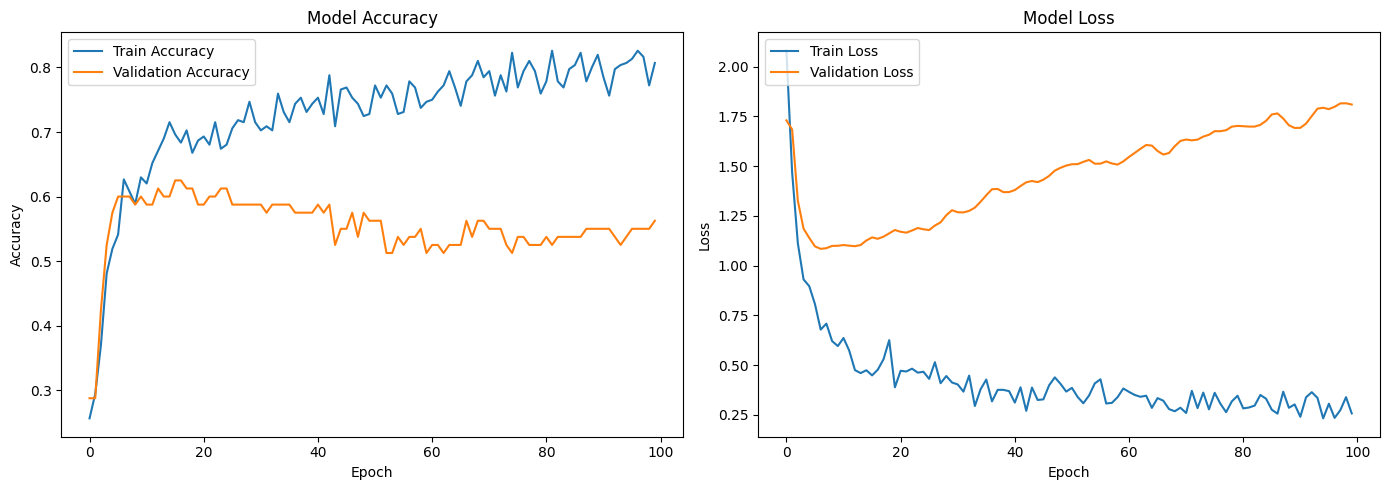

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Classification Report:
                     precision    recall  f1-score   support

Borderline-reactive       0.30      0.43      0.35        14
Moderately-reactive       0.00      0.00      0.00         5
       Non-reactive       0.00      0.00      0.00         5
           Reactive       0.78      0.70      0.74        56

           accuracy                           0.56        80
          macro avg       0.27      0.28      0.27        80
       weighted avg       0.60      0.56      0.58        80

✅ Classification report saved to: ./plots/classification_report.txt
✅ Confusion matrix saved to: ./plots/confusion_matrix.png


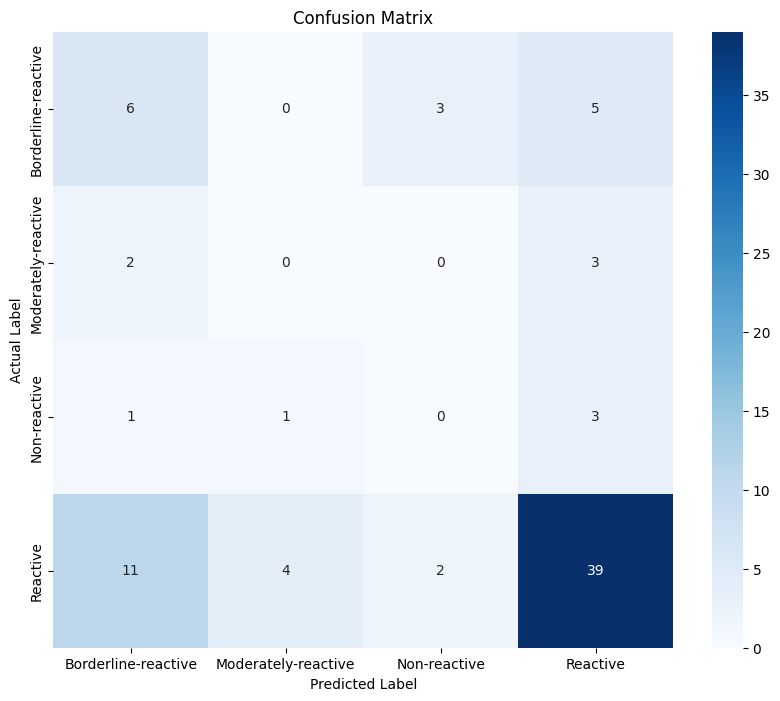

In [37]:
# --- MAIN EXECUTION SCRIPT ---

# 1. Load the data and the label encoder
X_data, Y_data, le = load_dataset(trim_factor=1200)

# 2. Split data into training (80%) and testing (20%) sets
# Use stratify to ensure class distribution is the same in train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X_data, Y_data, test_size=0.20, random_state=42, stratify=Y_data
)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


# 3. Train the Final Model on the training split
def train_final_model(trainX, trainY, valX, valY, best_kernel_size):
    """
    Trains the final model using the best hyperparameter.
    """
    print(f"\n--- Starting Final Training with kernel_size = {best_kernel_size} ---")
    
    # Define model parameters
    epochs, batch_size = 100, 64
    n_timesteps, n_features, num_classes = trainX.shape[1], trainX.shape[2], trainY.shape[1]

    # Build and compile the model
    final_model = convolutional_model_new2(n_timesteps, n_features, best_kernel_size, num_classes)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=100000, decay_rate=0.96, staircase=True)
    final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

    # Calculate class weights for the TRAINING dataset
    trainY_integers = np.argmax(trainY, axis=1)
    class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(trainY_integers), y=trainY_integers)
    class_weights = dict(enumerate(class_weights_array))
    print("Calculated class weights:", class_weights)

    # Train the model
    history = final_model.fit(
        trainX, trainY,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=0,
        class_weight=class_weights,
        validation_data=(valX, valY) # Use test set as validation data for history plot
    )
    
    # Save the final model
    save_path = './saved_model/final_model'
    os.makedirs(save_path, exist_ok=True)
    model_filepath = os.path.join(save_path, 'fetosense_cnn_model.keras')
    final_model.save(model_filepath)
    print(f"\n✅ Final model successfully trained and saved to: {model_filepath}")
    
    return final_model, history

# Set the best hyperparameter found from your experiments
best_param = 2

# Train the model
final_model, history = train_final_model(X_train, Y_train, X_test, Y_test, best_kernel_size=best_param)

# 4. Evaluate on the test set and generate visuals
generate_performance_visuals(final_model, history, X_test, Y_test, le)